# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

def summary_with_rf(model, input_size, batch_size=-1, device="cuda", dtypes=None, debug=False):
    """
    Enhanced torchsummary that calculates and displays receptive fields
    
    Args:
        model: PyTorch model
        input_size: Input tensor size (C, H, W) or tuple of sizes for multiple inputs
        batch_size: Batch size for summary (default: -1)
        device: Device to run model on (default: "cuda")
        dtypes: Data types for inputs (default: None, uses torch.FloatTensor)
        debug: If True, prints detailed RF calculations (Nin, Nout, k, s, p, Jin, Jout, Rin, Rout)
        
    Returns:
        None (prints summary table)
    """
    
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)
            
            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size
                
            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params
            
            # Calculate receptive field
            rf_info = calculate_rf_for_layer(module, m_key)
            summary[m_key]["receptive_field"] = rf_info

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    # Initialize RF tracking
    current_rf = 1
    current_jump = 1
    current_size = input_size[1] if isinstance(input_size, (tuple, list)) and len(input_size) > 1 else input_size[0] if isinstance(input_size, (tuple, list)) else 28
    original_input_size = current_size  # Keep track of original input size

    def calculate_rf_for_layer(module, layer_name):
        nonlocal current_rf, current_jump, current_size
        
        if isinstance(module, nn.Conv2d):
            kernel_size = module.kernel_size[0] if isinstance(module.kernel_size, tuple) else module.kernel_size
            stride = module.stride[0] if isinstance(module.stride, tuple) else module.stride
            padding = module.padding[0] if isinstance(module.padding, tuple) else module.padding
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
            new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
            
            # Calculate new RF: RFout = RFin + (k-1) * Jin
            new_rf = current_rf + (kernel_size - 1) * current_jump
            
            # Calculate new Jump: Jout = s * Jin
            new_jump = stride * current_jump
            
            if debug:
                print(f"\n[DEBUG] {layer_name} (Conv2d):")
                print(f"  Nin={old_size}, Nout={new_size}, k={kernel_size}, s={stride}, p={padding}")
                print(f"  Jin={old_jump}, Jout={new_jump}")
                print(f"  Rin={old_rf}, Rout={new_rf}")
                print(f"  Formula: Nout = 1 + ({old_size} + 2*{padding} - {kernel_size})/{stride} = {new_size}")
                print(f"  Formula: Rout = {old_rf} + ({kernel_size}-1)*{old_jump} = {new_rf}")
                print(f"  Formula: Jout = {stride}*{old_jump} = {new_jump}")
            
            current_size = new_size
            current_rf = new_rf
            current_jump = new_jump
            
            return new_rf
            
        elif isinstance(module, nn.MaxPool2d):
            kernel_size = module.kernel_size
            stride = module.stride if module.stride is not None else kernel_size
            padding = module.padding
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
            new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
            
            # Calculate new RF: RFout = RFin + (k-1) * Jin
            new_rf = current_rf + (kernel_size - 1) * current_jump
            
            # Calculate new Jump: Jout = s * Jin
            new_jump = stride * current_jump
            
            if debug:
                print(f"\n[DEBUG] {layer_name} (MaxPool2d):")
                print(f"  Nin={old_size}, Nout={new_size}, k={kernel_size}, s={stride}, p={padding}")
                print(f"  Jin={old_jump}, Jout={new_jump}")
                print(f"  Rin={old_rf}, Rout={new_rf}")
                print(f"  Formula: Nout = 1 + ({old_size} + 2*{padding} - {kernel_size})/{stride} = {new_size}")
                print(f"  Formula: Rout = {old_rf} + ({kernel_size}-1)*{old_jump} = {new_rf}")
                print(f"  Formula: Jout = {stride}*{old_jump} = {new_jump}")
            
            current_size = new_size
            current_rf = new_rf
            current_jump = new_jump
            
            return new_rf
            
        elif isinstance(module, nn.AdaptiveAvgPool2d):
            # FIXED: Properly handle AdaptiveAvgPool2d
            output_size = module.output_size
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Check if it's global pooling (output size is 1x1)
            if (isinstance(output_size, int) and output_size == 1) or \
               (isinstance(output_size, (tuple, list)) and output_size[0] == 1 and output_size[1] == 1):
                # Global Average Pooling - kernel size equals current spatial dimension
                # Calculate RF properly using the formula: RFout = RFin + (k-1) * Jin
                # For GAP, kernel_size = current_size
                new_rf = current_rf + (current_size - 1) * current_jump
                
                # Display string shows it's global pooling with the actual feature map size
                display_rf = f"GLOBAL({current_size}x{current_size})"
                
                if debug:
                    print(f"\n[DEBUG] {layer_name} (AdaptiveAvgPool2d - Global):")
                    print(f"  Nin={old_size}, Nout=1, k={old_size} (adaptive), s={old_size}, p=0")
                    print(f"  Jin={old_jump}, Jout=1 (global pooling)")
                    print(f"  Rin={old_rf}, Rout={new_rf}")
                    print(f"  Formula: Rout = {old_rf} + ({old_size}-1)*{old_jump} = {new_rf}")
                    print(f"  Note: Global Average Pooling - each output sees entire {old_size}x{old_size} feature map")
                    if new_rf >= original_input_size:
                        print(f"  RF exceeds input size ({new_rf} >= {original_input_size}) - complete coverage of {original_input_size}x{original_input_size} input")
                
                current_size = 1
                current_rf = new_rf  # Use the correctly calculated RF
                current_jump = 1  # Jump becomes 1 after global pooling
                
                # Return display string for table, but internally track the actual RF value
                return display_rf
            else:
                # For other adaptive pool sizes, calculate approximate RF
                # This is a simplification - actual RF depends on input/output ratio
                if isinstance(output_size, int):
                    out_h = out_w = output_size
                else:
                    out_h, out_w = output_size
                
                # Approximate kernel size based on input/output ratio
                approx_kernel_h = current_size // out_h
                approx_kernel_w = current_size // out_w
                approx_kernel = max(approx_kernel_h, approx_kernel_w)
                
                # Update RF based on approximate kernel
                new_rf = current_rf + (approx_kernel - 1) * current_jump
                
                if debug:
                    print(f"\n[DEBUG] {layer_name} (AdaptiveAvgPool2d):")
                    print(f"  Nin={old_size}, Nout={out_h}, k≈{approx_kernel} (adaptive), s≈{approx_kernel}, p=0")
                    print(f"  Jin={old_jump}, Jout={old_jump}")
                    print(f"  Rin={old_rf}, Rout={new_rf}")
                    print(f"  Note: Non-global adaptive pooling to {out_h}x{out_w}")
                
                current_size = out_h  # Assuming square output
                current_rf = new_rf
                
                return new_rf
                
        elif isinstance(module, (nn.BatchNorm2d, nn.Dropout, nn.ReLU)):
            # These layers don't change receptive field
            if debug:
                print(f"\n[DEBUG] {layer_name} ({module.__class__.__name__}):")
                print(f"  No change in RF: Nin={current_size}, Nout={current_size}")
                print(f"  Jin={current_jump}, Jout={current_jump}")
                print(f"  Rin={current_rf}, Rout={current_rf}")
            return current_rf
            
        elif isinstance(module, nn.Linear):
            # Linear layers typically come after flattening, RF stays the same
            if debug:
                print(f"\n[DEBUG] {layer_name} (Linear):")
                print(f"  After flattening - RF stays at {current_rf}")
            return current_rf
            
        else:
            # For unknown layers, assume RF doesn't change
            if debug:
                print(f"\n[DEBUG] {layer_name} ({module.__class__.__name__}):")
                print(f"  Unknown layer type - RF unchanged at {current_rf}")
            return current_rf

    # Check device
    device = device.type
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # Multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]
    if isinstance(input_size[0], (list, tuple)):
        input_size = input_size
    else:
        input_size = [input_size]

    # Batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]

    # Create properties
    summary = OrderedDict()
    hooks = []

    # Register hook
    model.apply(register_hook)

    # Make a forward pass
    model(*x)

    # Remove these hooks
    for h in hooks:
        h.remove()

    # Print summary
    if debug:
        print("\n" + "=" * 80)
        print("DEBUG MODE: Detailed RF Calculations Complete")
        print("=" * 80 + "\n")
    
    print("=" * 80)
    line_new = "{:>25}  {:>25} {:>15} {:>15}".format(
        "Layer (type)", "Output Shape", "Param #", "RF"
    )
    print(line_new)
    print("=" * 80)
    
    total_params = 0
    total_output = 0
    trainable_params = 0
    
    for layer in summary:
        # Input_shape, output_shape, trainable, nb_params
        rf_display = str(summary[layer]["receptive_field"])
        line_new = "{:>25}  {:>25} {:>15} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
            rf_display,
        )
        total_params += summary[layer]["nb_params"]

        total_output_size = abs(np.prod(summary[layer]["output_shape"]))
        total_output += total_output_size

        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # Assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(sum(input_size, ())))
    total_output_size = abs(2.0 * total_output * 4.0 / (1024 ** 2.0))  # x2 for gradients
    total_params_size = abs(total_params * 4.0 / (1024 ** 2.0))
    total_input_size = abs(total_input_size * 4.0 / (1024 ** 2.0))

    print("=" * 80)
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("-" * 80)
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % (total_params_size + total_output_size + total_input_size))
    print("=" * 80)
    # Display final RF
    final_rf_display = f"GLOBAL({original_input_size}x{original_input_size})" if isinstance(current_rf, int) and current_rf >= original_input_size else str(current_rf)
    print(f"Final Receptive Field: {final_rf_display}")
    print("=" * 80)


# Helper function to calculate RF for functional operations
def calculate_functional_rf(operation_name, current_rf, current_jump, current_size, **kwargs):
    """
    Calculate RF for functional operations like F.max_pool2d, F.conv2d, etc.
    
    Args:
        operation_name: Name of the operation ('max_pool2d', 'conv2d', etc.)
        current_rf: Current receptive field
        current_jump: Current jump
        current_size: Current spatial size
        **kwargs: Operation-specific parameters
        
    Returns:
        tuple: (new_rf, new_jump, new_size)
    """
    
    if operation_name == 'max_pool2d':
        kernel_size = kwargs.get('kernel_size', 2)
        stride = kwargs.get('stride', kernel_size)
        padding = kwargs.get('padding', 0)
        
        # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
        new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
        
        # Calculate new RF: RFout = RFin + (k-1) * Jin
        new_rf = current_rf + (kernel_size - 1) * current_jump
        
        # Calculate new Jump: Jout = s * Jin
        new_jump = stride * current_jump
        
        return new_rf, new_jump, new_size
        
    elif operation_name == 'avg_pool2d':
        # Same calculation as max_pool2d
        return calculate_functional_rf('max_pool2d', current_rf, current_jump, current_size, **kwargs)
        
    elif operation_name == 'adaptive_avg_pool2d':
        # FIXED: Handle adaptive pooling
        output_size = kwargs.get('output_size', 1)
        
        if output_size == 1 or output_size == (1, 1):
            # Global pooling - RF becomes the entire feature map
            return 'GLOBAL', 1, 1
        else:
            # For other sizes, approximate
            if isinstance(output_size, int):
                out_size = output_size
            else:
                out_size = output_size[0]  # Assuming square
            
            approx_kernel = current_size // out_size
            new_rf = current_rf + (approx_kernel - 1) * current_jump
            return new_rf, current_jump, out_size
        
    elif operation_name in ['relu', 'dropout']:
        # These don't change RF
        return current_rf, current_jump, current_size
        
    else:
        # Unknown operation, assume no change
        return current_rf, current_jump, current_size



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/vision/stable/transforms.html)

# The model
Let's start with the model we first saw

In [4]:
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        
        dropout = 0.1

        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)  # 28x28x1 > 26x26x8
        self.bn1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(8, 16, 3, bias=False)  # 26x26x8 > 24x24x16
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv2d(16, 8, 1, bias=False)  # 24x24x16 > 24x24x8
        self.bn3 = nn.BatchNorm2d(8)
        self.dropout3 = nn.Dropout(dropout)
        self.pool1 = nn.MaxPool2d(2, 2)  # 24x24x16 > 12x12x8
        self.conv4 = nn.Conv2d(8, 18, 3, bias=False)  # 12x12x8 > 10x10x16
        self.bn4 = nn.BatchNorm2d(18)
        self.dropout4 = nn.Dropout(dropout)
        self.conv5 = nn.Conv2d(18, 8, 3, bias=False)  # 10x10x16 > 8x8x8
        self.bn5 = nn.BatchNorm2d(8)
        self.dropout5 = nn.Dropout(dropout)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)  # 8x8x8 > 6x6x16
        self.bn6 = nn.BatchNorm2d(16)
        self.dropout6 = nn.Dropout(dropout)
        self.conv7 = nn.Conv2d(16, 16, 3, bias=False)  # 6x6x16 > 4x4x16
        self.bn7 = nn.BatchNorm2d(16)
        self.dropout7 = nn.Dropout(dropout)
        self.gap = nn.AdaptiveAvgPool2d(1)  # 4x4x16 > 1x1x16
        self.conv8 = nn.Conv2d(16, 10, 1, bias=False)  # 1x1x16 > 1x1x10
        self.bn8 = nn.BatchNorm2d(10)
        self.dropout8 = nn.Dropout(dropout)
        

    def forward(self, x):
        x = self.dropout2(F.relu(self.bn2(self.conv2(self.dropout1(F.relu(self.bn1(self.conv1(x))))))))
        x = self.pool1(self.dropout3(self.bn3(F.relu(self.conv3(x)))))
        x = self.dropout4(self.bn4(F.relu(self.conv4(x))))
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.dropout5(x)
        x = self.bn6(F.relu(self.conv6(x)))
        #x = self.dropout6(x)
        x = self.bn7(F.relu(self.conv7(x)))  # 1x1 convolution to map 14 channels to 10
        #x = self.dropout7(x)
        x = self.gap(x)  # Global average pooling to 1x1x14
        x = self.bn8(F.relu(self.conv8(x)))
        #x = self.dropout8(x)
        #x = self.conv_out(x)  # 1x1 convolution to map 14 channels to 10
        x = x.view(-1, 10)  # Flatten to (batch_size, 10)
        return F.log_softmax(x, dim=-1)
 

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net_3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
           Dropout-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 18, 10, 10]           1,296
      BatchNorm2d-12           [-1, 18, 10, 10]              36
          Dropout-13           [-1, 18, 10, 10]               0
           Conv2d-14              [-1, 

In [12]:
print("\n" + "="*50)
print("Enhanced Summary with Receptive Field:")
print("="*50)
summary_with_rf(model, input_size=(1, 28, 28), device=device, debug=True)


Enhanced Summary with Receptive Field:

[DEBUG] Conv2d-1 (Conv2d):
  Nin=28, Nout=26, k=3, s=1, p=0
  Jin=1, Jout=1
  Rin=1, Rout=3
  Formula: Nout = 1 + (28 + 2*0 - 3)/1 = 26
  Formula: Rout = 1 + (3-1)*1 = 3
  Formula: Jout = 1*1 = 1

[DEBUG] BatchNorm2d-2 (BatchNorm2d):
  No change in RF: Nin=26, Nout=26
  Jin=1, Jout=1
  Rin=3, Rout=3

[DEBUG] Dropout-3 (Dropout):
  No change in RF: Nin=26, Nout=26
  Jin=1, Jout=1
  Rin=3, Rout=3

[DEBUG] Conv2d-4 (Conv2d):
  Nin=26, Nout=24, k=3, s=1, p=0
  Jin=1, Jout=1
  Rin=3, Rout=5
  Formula: Nout = 1 + (26 + 2*0 - 3)/1 = 24
  Formula: Rout = 3 + (3-1)*1 = 5
  Formula: Jout = 1*1 = 1

[DEBUG] BatchNorm2d-5 (BatchNorm2d):
  No change in RF: Nin=24, Nout=24
  Jin=1, Jout=1
  Rin=5, Rout=5

[DEBUG] Dropout-6 (Dropout):
  No change in RF: Nin=24, Nout=24
  Jin=1, Jout=1
  Rin=5, Rout=5

[DEBUG] Conv2d-7 (Conv2d):
  Nin=24, Nout=24, k=1, s=1, p=0
  Jin=1, Jout=1
  Rin=5, Rout=5
  Formula: Nout = 1 + (24 + 2*0 - 1)/1 = 24
  Formula: Rout = 5 + (1-

# Dataset and Creating Train/Test Split

# Dataloader Arguments & Test/Train Dataloaders


In [97]:
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms

#Enhanced data augmentation pipeline for better generalization

train_transform = transforms.Compose([

                        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian Blur
                        transforms.RandomRotation(degrees=10), 
                        transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9, 1.1), shear=5),
                        #transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
                        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                        transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3)),
                        transforms.ToTensor(), 
                        transforms.Normalize((0.1307,), (0.3081,))
])


# Clean validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Load the full training dataset (60K samples)
full_train_dataset = datasets.MNIST('../data', train=True, download=True, transform=None)

# Split 60K into 50K train + 10K validation
train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Step 4: Apply specific transforms to the train and test datasets
# Wrap the datasets with the appropriate transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                          shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                        shuffle=False, **kwargs)

print(f"Training set size: {len(train_dataset)}")      # 50,000
print(f"Validation set size: {len(val_dataset)}")      # 10,000

Training set size: 50000
Validation set size: 10000


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

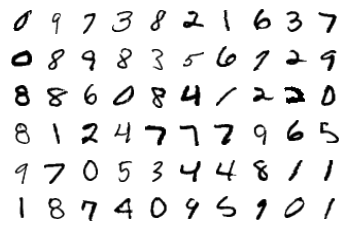

In [74]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)

%matplotlib inline
import matplotlib.pyplot as plt
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [75]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
           Dropout-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,440
      BatchNorm2d-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14              

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [76]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # Display current learning rate
    current_lr = scheduler.get_last_lr()[0]
    pbar.set_description(f'Epoch={epoch} LR={current_lr:.5f} Loss={loss.item():.4f} Batch_id={batch_idx}, Acc={100*correct/processed:.2f}')
    
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [98]:
from torch.optim.lr_scheduler import StepLR
model =  Net_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.004, momentum=0.9)


# Use OneCycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=15,
    steps_per_epoch=len(train_loader)
)

#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, val_loader)

EPOCH: 0


Epoch=0 LR=0.01524 Loss=0.0920 Batch_id=390, Acc=90.31: 100%|██████████| 391/391 [00:05<00:00, 66.11it/s] 



Test set: Average loss: 0.1588, Accuracy: 9552/10000 (95.52%)

EPOCH: 1


Epoch=1 LR=0.04370 Loss=0.0525 Batch_id=390, Acc=97.20: 100%|██████████| 391/391 [00:06<00:00, 56.46it/s] 



Test set: Average loss: 0.0743, Accuracy: 9781/10000 (97.81%)

EPOCH: 2


Epoch=2 LR=0.07605 Loss=0.0301 Batch_id=390, Acc=97.75: 100%|██████████| 391/391 [00:06<00:00, 59.21it/s] 



Test set: Average loss: 0.0492, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Epoch=3 LR=0.09713 Loss=0.0329 Batch_id=390, Acc=98.20: 100%|██████████| 391/391 [00:04<00:00, 81.30it/s] 



Test set: Average loss: 0.0489, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Epoch=4 LR=0.09944 Loss=0.0782 Batch_id=390, Acc=98.44: 100%|██████████| 391/391 [00:05<00:00, 70.14it/s] 



Test set: Average loss: 0.0394, Accuracy: 9880/10000 (98.80%)

EPOCH: 5


Epoch=5 LR=0.09503 Loss=0.0040 Batch_id=390, Acc=98.55: 100%|██████████| 391/391 [00:08<00:00, 48.06it/s]



Test set: Average loss: 0.0354, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Epoch=6 LR=0.08663 Loss=0.0097 Batch_id=390, Acc=98.76: 100%|██████████| 391/391 [00:05<00:00, 72.55it/s] 



Test set: Average loss: 0.0280, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Epoch=7 LR=0.07497 Loss=0.0177 Batch_id=390, Acc=98.73: 100%|██████████| 391/391 [00:06<00:00, 56.48it/s] 



Test set: Average loss: 0.0326, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Epoch=8 LR=0.06109 Loss=0.0069 Batch_id=390, Acc=98.87: 100%|██████████| 391/391 [00:03<00:00, 109.97it/s]



Test set: Average loss: 0.0291, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Epoch=9 LR=0.04623 Loss=0.1083 Batch_id=390, Acc=99.02: 100%|██████████| 391/391 [00:05<00:00, 77.56it/s] 



Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Epoch=10 LR=0.03170 Loss=0.0265 Batch_id=390, Acc=99.03: 100%|██████████| 391/391 [00:05<00:00, 70.42it/s] 



Test set: Average loss: 0.0254, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Epoch=11 LR=0.01880 Loss=0.0031 Batch_id=390, Acc=99.09: 100%|██████████| 391/391 [00:03<00:00, 123.20it/s]



Test set: Average loss: 0.0252, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Epoch=12 LR=0.00867 Loss=0.0022 Batch_id=390, Acc=99.19: 100%|██████████| 391/391 [00:05<00:00, 76.46it/s] 



Test set: Average loss: 0.0218, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Epoch=13 LR=0.00221 Loss=0.0046 Batch_id=390, Acc=99.30: 100%|██████████| 391/391 [00:07<00:00, 53.75it/s] 



Test set: Average loss: 0.0215, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Epoch=14 LR=0.00000 Loss=0.0016 Batch_id=390, Acc=99.35: 100%|██████████| 391/391 [00:03<00:00, 118.88it/s]



Test set: Average loss: 0.0218, Accuracy: 9943/10000 (99.43%)



In [99]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

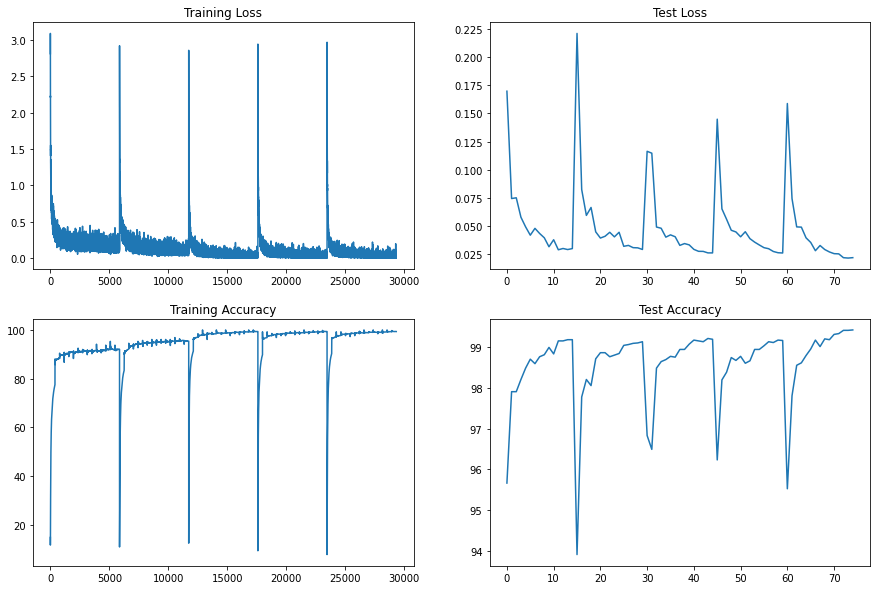

In [100]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")